Example of using nnet_survival to train a simple survival model using PyTorch.

Load libraries, including nnet_survival:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader

import nnet_survival_pytorch


Create 39 equally spaced intervals for follow-up time, from 0 to 5 years.

Create data for 5000 simulated patients. There is one covariate (call it x). The first half of the patients have x=0, and have exponential survival distribution with half-life 200 days. The second half of the patients have x=1, and have exponential survival distribution with half-life 400 days. Some patients are censored, with censoring half-life of 400 days.

In [14]:
breaks=np.arange(0.,365.*5,365./8)
n_intervals=len(breaks)-1
timegap = breaks[1:] - breaks[:-1]

halflife1 = 200
halflife2 = 400
halflife_cens = 400
n_samples=5000
np.random.seed(seed=0)
t1 = np.random.exponential(scale=1 / (np.log(2)/halflife1), size=int(n_samples/2))
t2 = np.random.exponential(scale=1 / (np.log(2)/halflife2), size=int(n_samples/2))
t=np.concatenate((t1, t2))
censtime = np.random.exponential(scale=1 / (np.log(2)/(halflife_cens)), size=n_samples)
f = t<censtime
t[~f] = censtime[~f]
x_train = np.zeros(n_samples)
x_train[int(n_samples/2):]=1

Convert each patient's output data from (time, censoring indicator) format to a vector that for each time interval specifies whether the patient survived that time interval, and whether the patient failed during that time interval:

In [15]:
y_train=nnet_survival_pytorch.make_surv_array(t,f,breaks)

PyTorch dataset and dataloader code

In [16]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        myItem = self.data[idx]
        myLabel = self.labels[idx]
        if self.transform:
            myItem = self.transform(myItem)
        myItem = torch.from_numpy(myItem).float()
        myLabel = torch.from_numpy(myLabel).float()
        return myItem, myLabel

batch_size=4
train_dataset = MyDataset(np.expand_dims(x_train,1), y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [17]:
device = ( #disabled mps because max_unpool2d not implemented yet
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 500 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    #test_loss, correct = 0, 0
    test_loss=0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    #correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [19]:
class SimpleSurvivalModel(nn.Module):
	def __init__(self, n_predictors, n_intervals):
		super(SimpleSurvivalModel, self).__init__()
		self.lin = nn.Linear(n_predictors, n_intervals)
		#self.weight = nn.Parameter(torch.zeros(n_intervals))
		#self.bias = nn.Parameter(torch.zeros(n_intervals))
	def forward(self, x):
		return F.sigmoid(self.lin(x))
		#return F.sigmoid(x @ self.weight + self.bias)
		#return x*self.weight+self.bias


Train model, usuing a custom loss function called surv_likelihood. For each time interval, a separate hazard rate is estimated.

In [20]:
learning_rate = 0.01
model = SimpleSurvivalModel(n_predictors=1, n_intervals=n_intervals).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
my_loss = nnet_survival_pytorch.surv_likelihood(n_intervals)

epochs = 2
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, my_loss, optimizer)

Epoch 1
-------------------------------
loss: 12.144847  [    4/ 5000]
loss: 9.847657  [ 2004/ 5000]
loss: 8.846896  [ 4004/ 5000]
Epoch 2
-------------------------------
loss: 5.456000  [    4/ 5000]
loss: 10.555038  [ 2004/ 5000]
loss: 8.998658  [ 4004/ 5000]


For each of the two groups, plot true survival distribution (Kaplan-Meier estimator) and compare to model-predicted survival. The model has good agreement with the true survival distribution.

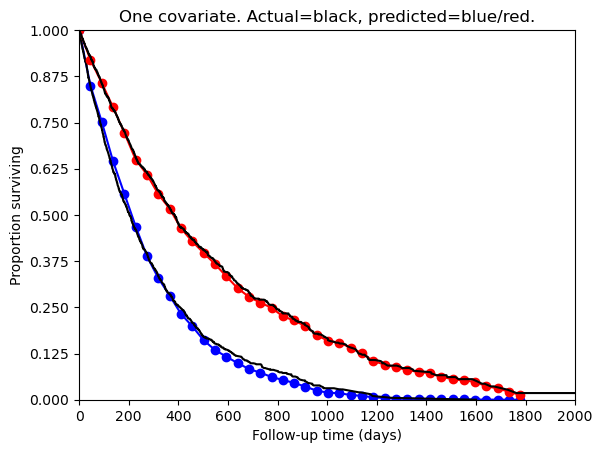

In [21]:
y_pred=model(torch.tensor(np.expand_dims(x_train,1)).float().to(device)).squeeze().detach().cpu().numpy()

kmf = KaplanMeierFitter()
kmf.fit(t[0:int(n_samples/2)], event_observed=f[0:int(n_samples/2)])
plt.plot(breaks,np.concatenate(([1],np.cumprod(y_pred[0,:]))),'bo-')
plt.plot(kmf.survival_function_.index.values, kmf.survival_function_.KM_estimate,color='k')
kmf.fit(t[int(n_samples/2)+1:], event_observed=f[int(n_samples/2)+1:])
plt.plot(breaks,np.concatenate(([1],np.cumprod(y_pred[-1,:]))),'ro-')
plt.plot(kmf.survival_function_.index.values, kmf.survival_function_.KM_estimate,color='k')
plt.xticks(np.arange(0, 2000.0001, 200))
plt.yticks(np.arange(0, 1.0001, 0.125))
plt.xlim([0,2000])
plt.ylim([0,1])
plt.xlabel('Follow-up time (days)')
plt.ylabel('Proportion surviving')
plt.title('One covariate. Actual=black, predicted=blue/red.')
plt.show()

It is easy to output a predicted survival curve for an individual, or a predicted survival probability at a specific follow-up time. For instance, print the predicted survival probability for the 100th individual at a follow-up time of 30 days:

In [22]:
pred_surv = nnet_survival_pytorch.nnet_pred_surv(y_pred, breaks, 30)
print(pred_surv[99])

0.8499921560287476
